In [1]:
!pip install docling

  Using cached beautifulsoup4-4.12.3-py3-none-any.whl.metadata (3.8 kB)
  Using cached deepsearch_glm-1.0.0-cp312-cp312-macosx_14_0_arm64.whl.metadata (11 kB)
  Using cached docling_parse-3.0.0-cp312-cp312-macosx_14_0_arm64.whl.metadata (7.5 kB)
  Using cached easyocr-1.7.2-py3-none-any.whl.metadata (10 kB)
  Using cached filetype-1.2.0-py2.py3-none-any.whl.metadata (6.5 kB)
  Using cached lxml-5.3.0-cp312-cp312-macosx_10_9_universal2.whl.metadata (3.8 kB)
  Using cached marko-2.1.2-py3-none-any.whl.metadata (4.5 kB)
  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached python_docx-1.1.2-py3-none-any.whl.metadata (2.0 kB)
  Using cached python_pptx-1.0.2-py3-none-any.whl.metadata (2.5 kB)
  Using cached Rtree-1.3.0-py3-none-macosx_11_0_arm64.whl.metadata (2.1 kB)
  Using cached typer-0.12.5-py3-none-any.whl.metadata (15 kB)
  Using cached soupsieve-2.6-py3-none-any.whl.metadata (4.6 kB)
  Using cached jsonlines-3.1.0-py3-none-any.whl.metadata (1.7 kB)
  Us

In [6]:
!pip install -q opencv-python supervision

### PARSE PDF

In [3]:
import logging
import time
from pathlib import Path
from docling_core.types.doc import ImageRefMode, PictureItem, TableItem
from docling.datamodel.base_models import FigureElement, InputFormat, Table
from docling.datamodel.pipeline_options import PdfPipelineOptions
from docling.document_converter import DocumentConverter, PdfFormatOption
_log = logging.getLogger(__name__)
IMAGE_RESOLUTION_SCALE = 5.0
logging.basicConfig(level=logging.INFO)

input_doc_path = Path("data/AT Plumbing Service Call Tree.pdf")
output_dir = Path("imgs")

pipeline_options = PdfPipelineOptions()
pipeline_options.images_scale = IMAGE_RESOLUTION_SCALE
pipeline_options.generate_page_images = True
pipeline_options.generate_picture_images = True

doc_converter = DocumentConverter(
    format_options={
        InputFormat.PDF: PdfFormatOption(pipeline_options=pipeline_options)
    }
)

start_time = time.time()

conv_res = doc_converter.convert(input_doc_path)

output_dir.mkdir(parents=True, exist_ok=True)
doc_filename = conv_res.input.file.stem

# Save page images
for page_no, page in conv_res.document.pages.items():
    page_no = page.page_no
    page_image_filename = output_dir / f"{doc_filename}-{page_no}.jpeg"
    with page_image_filename.open("wb") as fp:
        page.image.pil_image.save(fp, format="JPEG")

# Save images of figures and tables
table_counter = 0
picture_counter = 0
for element, _level in conv_res.document.iterate_items():
    if isinstance(element, TableItem):
        table_counter += 1
        element_image_filename = (
            output_dir / f"{doc_filename}-table-{table_counter}.jpeg"
        )
        with element_image_filename.open("wb") as fp:
            element.get_image(conv_res.document).save(fp, "JPEG")

    if isinstance(element, PictureItem):
        picture_counter += 1
        element_image_filename = (
            output_dir / f"{doc_filename}-picture-{picture_counter}.jpeg"
        )
        with element_image_filename.open("wb") as fp:
            element.get_image(conv_res.document).save(fp, "JPEG")

end_time = time.time() - start_time

_log.info(f"Document converted and figures exported in {end_time:.2f} seconds.")

INFO:docling.document_converter:Going to convert document batch...
INFO:docling.utils.accelerator_utils:Accelerator device: 'mps'
INFO:docling.utils.accelerator_utils:Accelerator device: 'mps'
INFO:docling.utils.accelerator_utils:Accelerator device: 'mps'
INFO:docling.pipeline.base_pipeline:Processing document AT Plumbing Service Call Tree.pdf
INFO:docling.document_converter:Finished converting document AT Plumbing Service Call Tree.pdf in 35.23 sec.
INFO:__main__:Document converted and figures exported in 35.40 seconds.


### GET NODES FOR VISUALIZATION

In [4]:
# RUN THIS JUST TO GET DATA TO SHOW ON IMAGE
import easyocr
reader = easyocr.Reader(['ch_sim','en'], )
verbose_nodes = reader.readtext("imgs/AT Plumbing Service Call Tree-1.jpeg",
                        detail = 1, paragraph=False,
                        canvas_size=5000,
                        decoder="wordbeamsearch",
                        ## experiment below. Ref: https://www.jaided.ai/easyocr/documentation/
                        beamWidth = 10,
                        width_ths=0.9, 
                        # height_ths=1.2,
                        text_threshold=0.6,
                        # x_ths=1,
                        # y_ths=1.9,
                        # ycenter_ths=0.7,
                        # mag_ratio=1.5,
                        )

Progress: |█████████████████████████████████████████████████-| 99.5% Complete

INFO:easyocr.easyocr:Download complete.


Progress: |██████████████████████████████████████████████████| 100.0% Complete

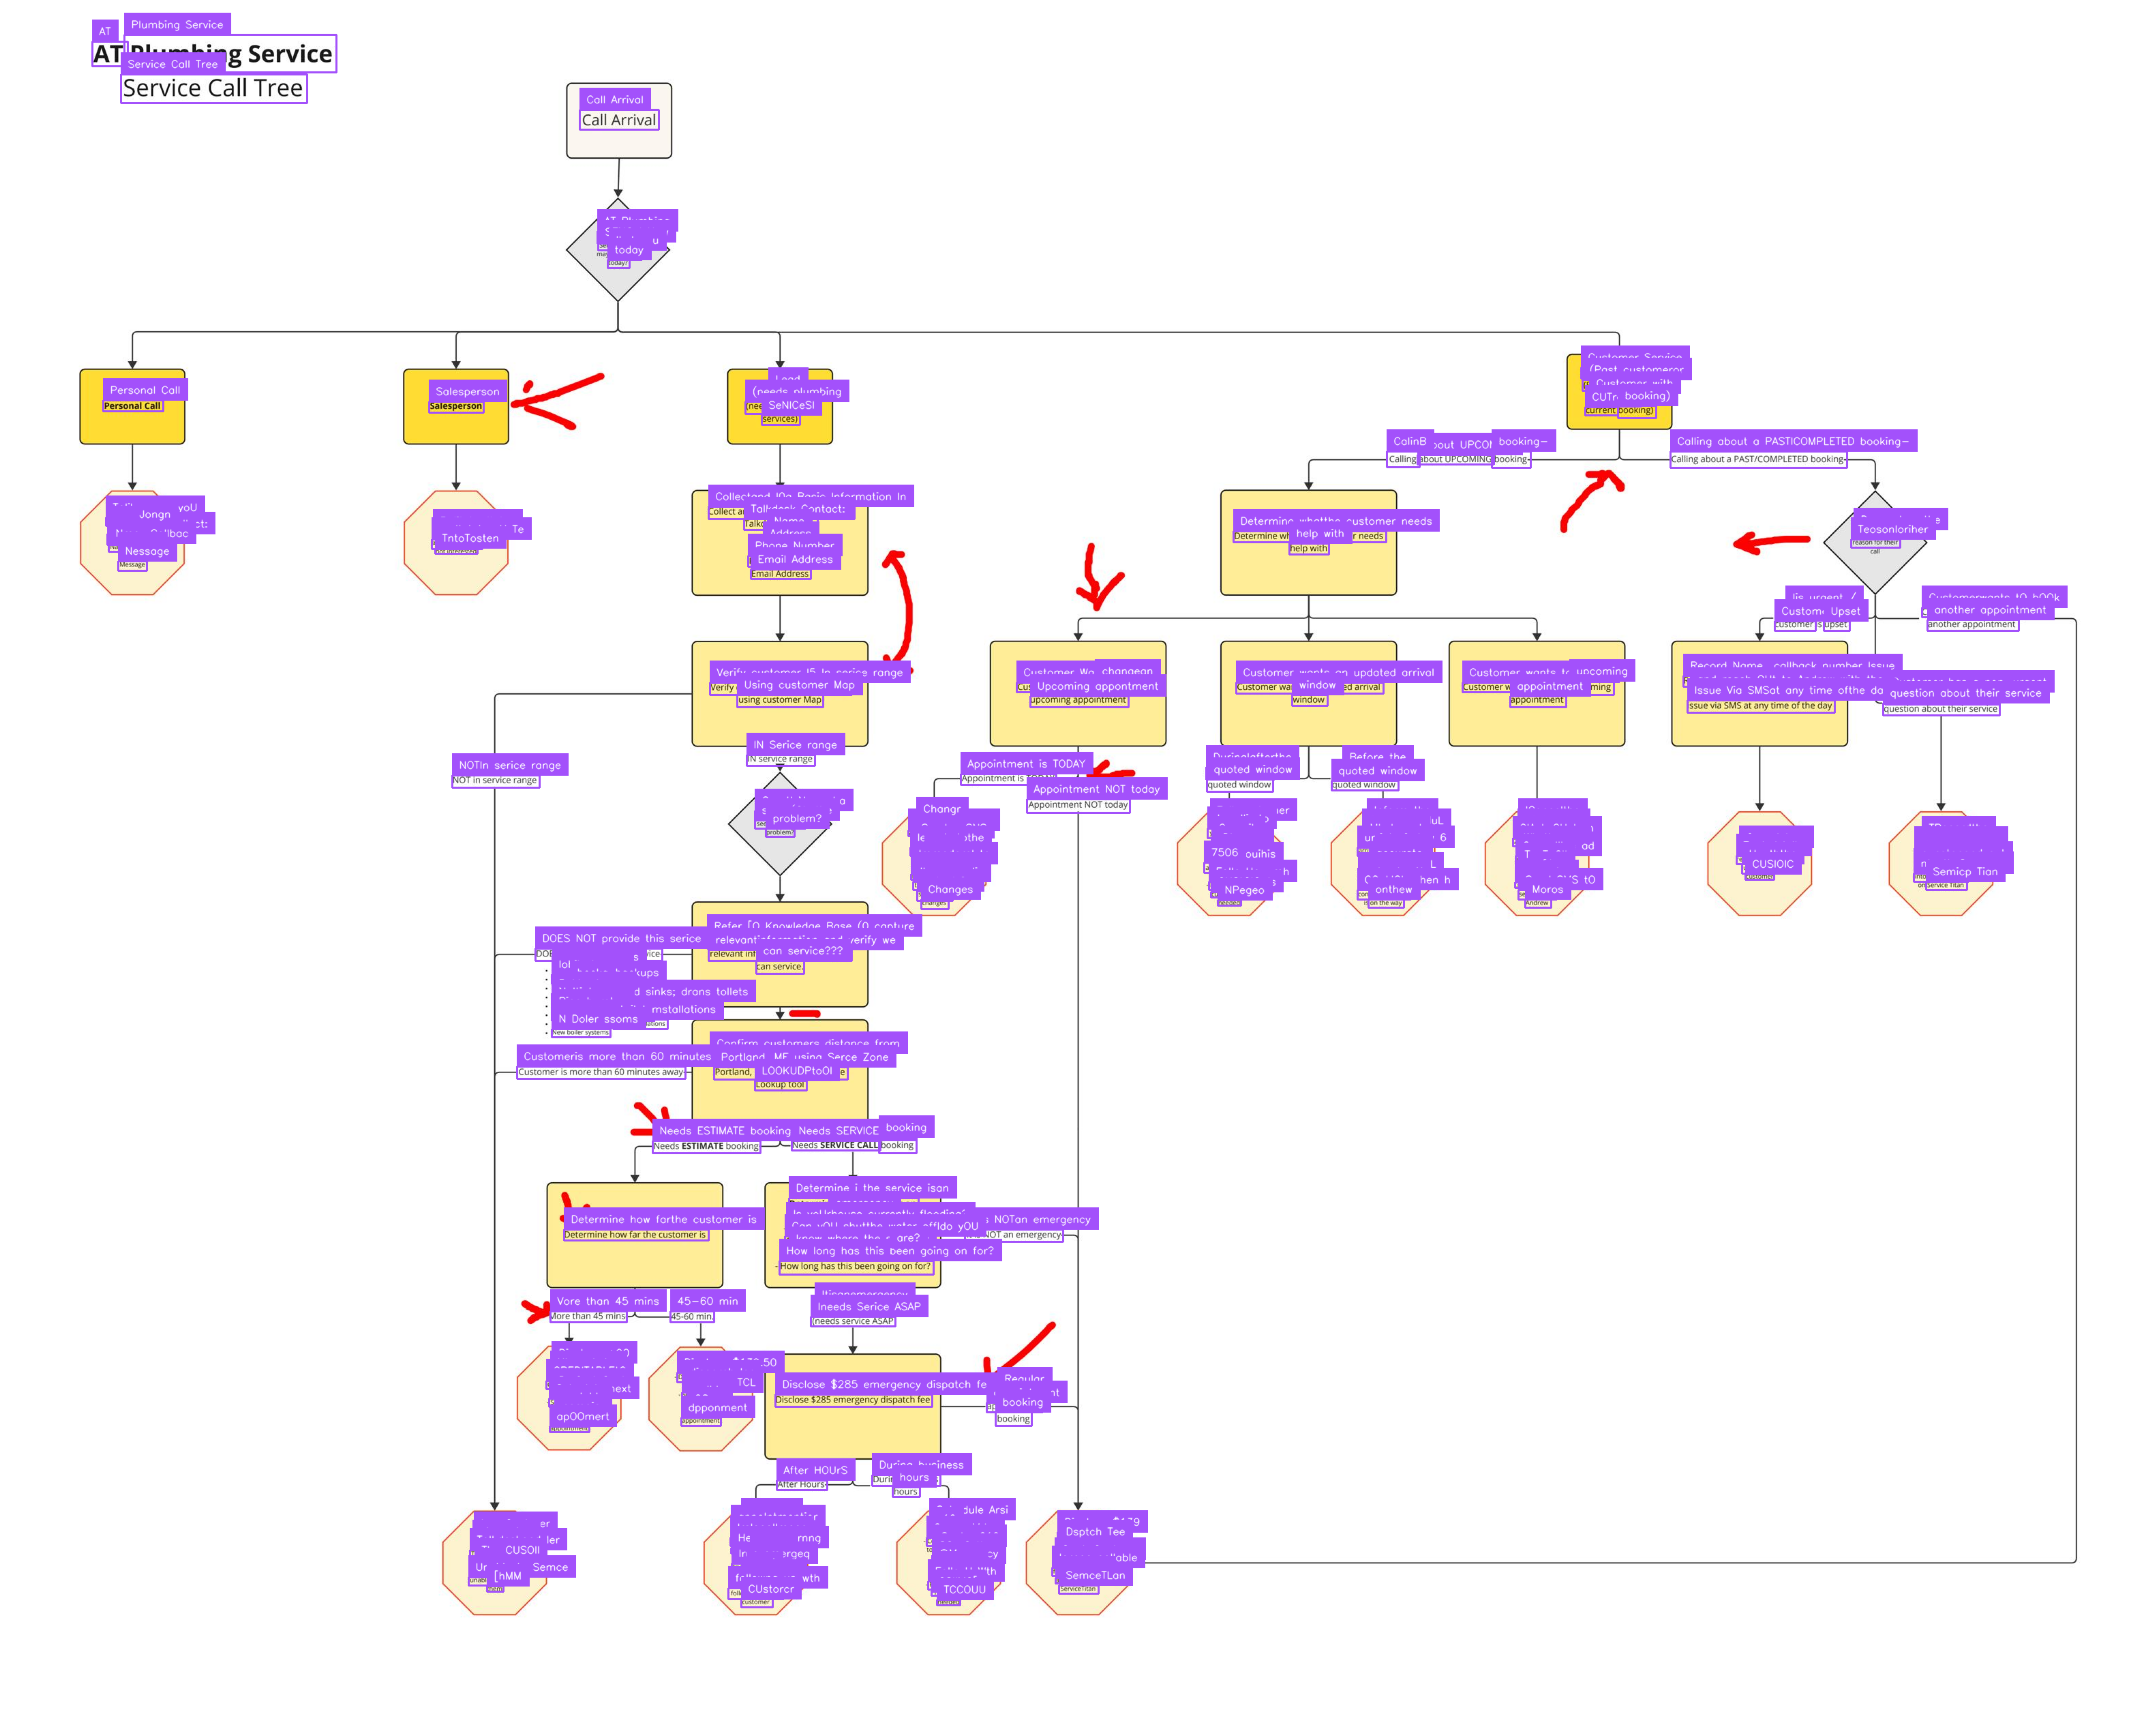

True

In [9]:
import supervision as sv
import cv2
import numpy as np

image = cv2.imread('imgs/AT Plumbing Service Call Tree-1.jpeg')

xyxy, confidences, class_ids, label = [], [], [], []

# Extract data from OCR result
for detection in verbose_nodes:
    bbox, text, confidence = detection[0], detection[1], detection[2]
   
    # Convert bounding box format
    x_min = int(min([point[0] for point in bbox]))
    y_min = int(min([point[1] for point in bbox]))
    x_max = int(max([point[0] for point in bbox]))
    y_max = int(max([point[1] for point in bbox]))
   
    # Append data to lists
    xyxy.append([x_min, y_min, x_max, y_max])
    label.append(text)
    confidences.append(confidence)
    class_ids.append(0)  

# Convert to NumPy arrays
detections = sv.Detections(
    xyxy=np.array(xyxy),
    confidence=np.array(confidences),
    class_id=np.array(class_ids)
)

# Annotate image with bounding boxes and labels
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = box_annotator.annotate(scene=image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections, labels=label)

# Display and save the annotated image
sv.plot_image(image=annotated_image, size=[100, 100])
cv2.imwrite("Output.jpg", annotated_image)

## GET NODES FOR PROMPT

In [1]:
import easyocr
reader = easyocr.Reader(['ch_sim','en'], )
nodes = reader.readtext("imgs/AT Plumbing Service Call Tree-1.jpeg",
                        detail = 0, paragraph=True,
                        canvas_size=5000,
                        decoder="wordbeamsearch",
                        ## experiment below. Ref: https://www.jaided.ai/easyocr/documentation/
                        beamWidth = 10,
                        width_ths=0.9, 
                        # height_ths=1.2,
                        text_threshold=0.6,
                        # x_ths=1,
                        # y_ths=1.9,
                        # ycenter_ths=0.7,
                        # mag_ratio=1.5,
                        )
nodes

['AT Plumbing Service Service Call Tree',
 'Call Arrival',
 'AT Plumbing SENCeI How Ihelpyou today',
 'Customer Service (Past customeror Customer with CUTrent booking)',
 'Lead',
 'Personal Call',
 'Salesperson',
 '(needs plumbing SeNICeSI',
 'CalinB about UPCOMING booking-',
 'Calling about a PASTICOMPLETED booking-',
 'Collectand I0g Basic Information In Talkdesk Contact: Name Address Phone Number Email Address',
 'Talihe CalleryoU VII 0a5 Jongn message; collect: Nme  Callbac NUIUeI Nessage',
 'Politely dtclne undtstst yoU Te TntoTosten',
 'Determine whatthe customer needs help with',
 'Derermlme the TeosonIoriher',
 'Iis urgent / Customer Upset',
 'Customerwants tO bOOk another appointment',
 'Record Name  callback number Issue and reach OUt to Andrew with the Issue Via SMSat any time ofthe day',
 'Verify customer I5 In serice range Using customer Map',
 'Customer Wants To changean Upcoming appontment',
 'Customer wants an updated arrival window',
 'Customer wants to cancel upcoming

### LINEARIZE DIAGRAM

In [3]:
import os
os.environ["ANTHROPIC_API_KEY"] = ""
import anthropic
import base64
from textwrap import dedent

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


image_path = "imgs/AT Plumbing Service Call Tree-1.jpeg"
base64_image = encode_image(image_path)

client = anthropic.Anthropic()

prompt = """The diagram in the provided image is a workflow process that describes steps or nodes that an customer service human agent handles phone calls from a person in different cases.
Your task is to interpret the diagram and generate workflow plan in YAML format.
Each box means a step.
### Strictly comply with the following rules:
- In the output, include all boxes and texts found in the diagram, and keep the texts as they are. Expand texts are they are in the original diagram.
- In the output, each Step corresponds with a box of any shape (rectangle, haxagon or diamond). Include all the nodes until you find no more.
- For a current decision step that leads to multiple possible steps, use if-clauses in the current step to show steps that may conditionally come next. This is crucial for your success.
- In the If-clause or in every Step, always use "go to Step <step_id>" as the reference to the next step. This is extremely important.
These are extremely important requirements you must follow.

The following elements are steps or conditions in the diagram. You have to consider them all together with the diagram when creating the output. Ensure to use all the elements in your output because they're the essential nodes and conditions.
### Elements to consider:
{nodes}

Here is an example illustrating the output template:
step_0: |
  - Determine user request intent
    - If user request is about personal (not related to a plumbing request), go to step_1
    - If user request is about selling something, go to step_2
    - If user request is about a new lead (needs plumbing services), go to step_3
    - If user request is about customer service (Past customer or customer with current booking), go to step_16

step_1: |
  - Tell the caller you will pass along a message and collect: Name Callback Number Message
  - Follow up with customer, if needed

step_2: |
  - Politely decline and insist you're not interested
  - End the call

step_3: |
  - Collect and log Basic Information in Talkdesk Contact: Name, Address, Phone Number, Email Address
  - Then go to step_4

step_4: |
  - Verify customer is in service range using the customer Map
    - If customer is NOT in service range, go to step_5
    - If customer is in service range, go to step_6

step_5: |
  - Log customer information in Talkdesk Contact
  - Let the customer know we are unable to service them
  - End the call

step_6: |
  - Refer to Knowledge Base to capture relevant information and verify we can service
    - If we cannot service, go to step_5
    - Else, go to step_7
""".format(nodes=nodes)

message = client.messages.create(
    model="claude-3-5-sonnet-20241022",
    temperature=0.1,
    max_tokens=4024,
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "source": {
                        "type": "base64",
                        "media_type": "image/jpeg",
                        "data": base64_image,
                    },
                },
                {
                    "type": "text",
                    "text": prompt
                }
            ],
        }
    ],
)

diagram_text = message.content[0].text
print(diagram_text)

I'll help create a YAML workflow based on the service call tree diagram. Here's the structured workflow:

```yaml
step_0: |
  - AT Plumbing Service Service Call Tree
  - Call Arrival
  - AT Plumbing Service: How may I help you today?
    - If Personal Call, go to step_1
    - If Salesperson, go to step_2
    - If Lead (needs plumbing services), go to step_3
    - If Customer Service (Past customer or Customer with current booking), go to step_4

step_1: |
  - Tell the caller you will pass along message; collect:
    - Name
    - Callback Number
    - Message
  - End call

step_2: |
  - Politely decline and insist you're not interested
  - End call

step_3: |
  - Collect and log Basic Information in Talkdesk Contact:
    - Name
    - Address
    - Phone Number
    - Email Address
  - Go to step_5

step_4: |
  - Determine what the customer needs help with
    - If calling about UPCOMING booking, go to step_6
    - If calling about a PAST/COMPLETED booking, go to step_7
    - If it is urg